In [58]:
import numpy as np
import matplotlib.pyplot as plt
from pygsp import graphs, filters, utils
#from additional_utils import get_approx_filter
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_random_state
from sklearn.datasets import make_moons
from sklearn import cluster, datasets, mixture

import time
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
import networkx as nx
import sys
from pygsp import graphs, filters, plotting, utils

N_NEIGHBOR = 10
N_LOW_DIMS = 2
LEARNING_RATE = 0.1
#LEARNING_RATE = 10
MAX_ITER = 100
## Upload data

import numpy as np
from numba import njit




In [59]:



@njit

def extract_value(arrays, i, j):
    """Extracts a value from a list of NumPy arrays."""
    return arrays[i][j]

# Example usage
a = [np.array([1, 2, 3]), np.array([4, 5, 6, 7]), np.array([8, 9])]
print(extract_value(a, 1, 2))



@njit
def random_access(arrays, n_iterations):
    for i in range(n_iterations):
        outer_index = np.random.choice(len(arrays))
        inner_index = np.random.choice(arrays[outer_index].shape[0])
        value = arrays[outer_index][inner_index]
        print(f"Randomly accessed value: {value}")

# Example usage
a = [np.array([1, 22, 33]), np.array([4, 5, 6, 7]), np.array([8, 9])]
random_access(a, 5)  # prints 5 randomly accessed values

from numba import njit, types
from numba.typed import List

@njit
def extract_value(arrays, i, j):
    """Extracts a value from a Numba List of NumPy arrays."""
    return arrays[i][j]

import numpy as np
import numba
import scipy
import matplotlib.pyplot as plt
import numba_dist as dist
from warnings import warn
from collections import deque, namedtuple
from sklearn.base import BaseEstimator
from scipy.optimize import curve_fit
from sklearn.utils import check_random_state
from pygsp import graphs, filters
from sklearn.metrics.pairwise import euclidean_distances
import igraph
from sklearn.neighbors import KernelDensity
from sklearn.neighbors import NearestNeighbors
import time

INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1
SMOOTH_K_TOLERANCE = 1e-5
MIN_K_DIST_SCALE = 1e-3
NPY_INFINITY = np.inf

def make_nn_descent(dist, dist_args):
    """Create a numba accelerated version of nearest neighbor descent
    specialised for the given distance metric and metric arguments. Numba
    doesn't support higher order functions directly, but we can instead JIT
    compile the version of NN-descent for any given metric.

    Parameters
    ----------
    dist: function
        A numba JITd distance function which, given two arrays computes a
        dissimilarity between them.

    dist_args: tuple
        Any extra arguments that need to be passed to the distance function
        beyond the two arrays to be compared.

    Returns
    -------
    A numba JITd function for nearest neighbor descent computation that is
    specialised to the given metric.
    """
    @numba.njit(parallel=True)
    def nn_descent(data, n_neighbors, rng_state, max_candidates=50,
                   n_iters=10, delta=0.001, rho=0.5,
                   rp_tree_init=True, leaf_array=None, verbose=False):
        n_vertices = data.shape[0]

        current_graph = make_heap(data.shape[0], n_neighbors)
        for i in range(data.shape[0]):
            indices = rejection_sample(n_neighbors, data.shape[0], rng_state)
            for j in range(indices.shape[0]):
                d = dist(data[i], data[indices[j]], *dist_args)
                heap_push(current_graph, i, d, indices[j], 1)
                heap_push(current_graph, indices[j], d, i, 1)

        if rp_tree_init:
            for n in range(leaf_array.shape[0]):
                for i in range(leaf_array.shape[1]):
                    if leaf_array[n, i] < 0:
                        break
                    for j in range(i + 1, leaf_array.shape[1]):
                        if leaf_array[n, j] < 0:
                            break
                        d = dist(data[leaf_array[n, i]], data[leaf_array[n, j]],
                                 *dist_args)
                        heap_push(current_graph, leaf_array[n, i], d,
                                  leaf_array[n, j],
                                  1)
                        heap_push(current_graph, leaf_array[n, j], d,
                                  leaf_array[n, i],
                                  1)

        for n in range(n_iters):
            if verbose:
                print("\tnn descent iteration ", n, " / ", n_iters)

            candidate_neighbors = build_candidates(current_graph, n_vertices,
                                                   n_neighbors, max_candidates,
                                                   rng_state)

            c = 0
            for i in range(n_vertices):
                for j in range(max_candidates):
                    p = int(candidate_neighbors[0, i, j])
                    if p < 0 or tau_rand(rng_state) < rho:
                        continue
                    for k in range(max_candidates):
                        q = int(candidate_neighbors[0, i, k])
                        if q < 0 or not candidate_neighbors[2, i, j] and not \
                                candidate_neighbors[2, i, k]:
                            continue

                        d = dist(data[p], data[q], *dist_args)
                        c += heap_push(current_graph, p, d, q, 1)
                        c += heap_push(current_graph, q, d, p, 1)

            if c <= delta * n_neighbors * data.shape[0]:
                break

        return current_graph[:2]

    return nn_descent

def rptree_leaf_array(data, n_neighbors, rng_state, n_trees=10, angular=False):
    """Generate an array of sets of candidate nearest neighbors by
    constructing a random projection forest and taking the leaves of all the
    trees. Any given tree has leaves that are a set of potential nearest
    neighbors. Given enough trees the set of all such leaves gives a good
    likelihood of getting a good set of nearest neighbors in composite. Since
    such a random projection forest is inexpensive to compute, this can be a
    useful means of seeding other nearest neighbor algorithms.

    Parameters
    ----------
    data: array of shape (n_samples, n_features)
        The data for which to generate nearest neighbor approximations.

    n_neighbors: int
        The number of nearest neighbors to attempt to approximate.

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    n_trees: int (optional, default 10)
        The number of trees to build in the forest construction.

    angular: bool (optional, default False)
        Whether to use angular/cosine distance for random projection tree
        construction.

    Returns
    -------
    leaf_array: array of shape (n_leaves, max(10, n_neighbors))
        Each row of leaf array is a list of indices found in a given leaf.
        Since not all leaves are the same size the arrays are padded out with -1
        to ensure we can return a single ndarray.
    """
    leaves = []
    try:
        leaf_size = max(10, n_neighbors)
        for t in range(n_trees):
            tree = make_tree(data,
                             np.arange(data.shape[0]),
                             rng_state,
                             leaf_size=leaf_size,
                             angular=angular)
            leaves += get_leaves(tree)

        leaf_array = -1 * np.ones([len(leaves), leaf_size], dtype=np.int64)
        for i, leaf in enumerate(leaves):
            leaf_array[i, :len(leaf)] = leaf
    except RecursionError:
        leaf_array = np.array([[-1]])

    return leaf_array

@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates,
                     rng_state):
    """Build a heap of candidate neighbors for nearest neighbor descent. For
    each vertex the candidate neighbors are any current neighbors, and any
    vertices that have the vertex as one of their nearest neighbors.

    Parameters
    ----------
    current_graph: heap
        The current state of the graph for nearest neighbor descent.

    n_vertices: int
        The total number of vertices in the graph.

    n_neighbors: int
        The number of neighbor edges per node in the current graph.

    max_candidates: int
        The maximum number of new candidate neighbors.

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    candidate_neighbors: A heap with an array of (randomly sorted) candidate
    neighbors for each vertex in the graph.
    """
    candidate_neighbors = make_heap(n_vertices, max_candidates)
    for i in range(n_vertices):
        for j in range(n_neighbors):
            if current_graph[0, i, j] < 0:
                continue
            idx = current_graph[0, i, j]
            isn = current_graph[2, i, j]
            d = tau_rand(rng_state)
            heap_push(candidate_neighbors, i, d, idx, isn)
            heap_push(candidate_neighbors, idx, d, i, isn)
            current_graph[2, i, j] = 0

    return candidate_neighbors

def make_tree(data, indices, rng_state, leaf_size=30, angular=False):
    """Construct a random projection tree based on ``data`` with leaves
    of size at most ``leaf_size``.

    Parameters
    ----------
    data: array of shape (n_samples, n_features)
        The original data to be split

    indices: array of shape (tree_node_size,)
        The indices of the elements in the ``data`` array that are to
        be split in the current operation. This should be np.arange(
        data.shape[0]) for a full tree build, and may be smaller when being
        called recursively for tree construction.

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    leaf_size: int (optional, default 30)
        The maximum size of any leaf node in the tree. Any node in the tree
        with more than ``leaf_size`` will be split further to create child
        nodes.

    angular: bool (optional, default False)
        Whether to use cosine/angular distance to create splits in the tree,
        or euclidean distance.

    Returns
    -------
    node: RandomProjectionTreeNode
        A random projection tree node which links to its child nodes. This
        provides the full tree below the returned node.
    """

    # Make a tree recursively until we get below the leaf size
    if indices.shape[0] > leaf_size:
        if angular:
            (left_indices,
             right_indices) = random_projection_cosine_split(data,
                                                             indices,
                                                             rng_state)
        else:
            left_indices, right_indices = random_projection_split(data,
                                                                  indices,
                                                                  rng_state)
        left_node = make_tree(data,
                              left_indices,
                              rng_state,
                              leaf_size,
                              angular)
        right_node = make_tree(data,
                               right_indices,
                               rng_state,
                               leaf_size,
                               angular)

        node = RandomProjectionTreeNode(indices, False, left_node, right_node)
    else:
        node = RandomProjectionTreeNode(indices, True, None, None)

    return node

def get_leaves(tree):
    """Return the set of leaf nodes of a random projection tree.

    Parameters
    ----------
    tree: RandomProjectionTreeNode
        The root node of the tree to get leaves of.

    Returns
    -------
    leaves: list
        A list of arrays of indices of points in each leaf node.
    """
    if tree.is_leaf:
        return [tree.indices]
    else:
        return get_leaves(tree.left_child) + get_leaves(tree.right_child)
    
@numba.njit('f8[:, :, :](i8,i8)')
def make_heap(n_points, size):
    """Constructor for the numba enabled heap objects. The heaps are used
    for approximate nearest neighbor search, maintaining a list of potential
    neighbors sorted by their distance. We also flag if potential neighbors
    are newly added to the list or not. Internally this is stored as
    a single ndarray; the first axis determines whether we are looking at the
    array of candidate indices, the array of distances, or the flag array for
    whether elements are new or not. Each of these arrays are of shape
    (``n_points``, ``size``)

    Parameters
    ----------
    n_points: int
        The number of data points to track in the heap.

    size: int
        The number of items to keep on the heap for each data point.

    Returns
    -------
    heap: An ndarray suitable for passing to other numba enabled heap functions.
    """
    result = np.zeros((3, n_points, size))
    result[0] = -1
    result[1] = np.infty
    result[2] = 0

    return result

@numba.jit('i8(f8[:,:,:],i8,f8,i8,i8)')
def heap_push(heap, row, weight, index, flag):
    """Push a new element onto the heap. The heap stores potential neighbors
    for each data point. The ``row`` parameter determines which data point we
    are addressing, the ``weight`` determines the distance (for heap sorting),
    the ``index`` is the element to add, and the flag determines whether this
    is to be considered a new addition.

    Parameters
    ----------
    heap: ndarray generated by ``make_heap``
        The heap object to push into

    row: int
        Which actual heap within the heap object to push to

    weight: float
        The priority value of the element to push onto the heap

    index: int
        The actual value to be pushed

    flag: int
        Whether to flag the newly added element or not.

    Returns
    -------
    success: The number of new elements successfully pushed into the heap.
    """
    indices = heap[0, row]
    weights = heap[1, row]
    is_new = heap[2, row]

    if weight > weights[0]:
        return 0

    # break if we already have this element.
    for i in range(indices.shape[0]):
        if index == indices[i]:
            return 0

    # insert val at position zero
    weights[0] = weight
    indices[0] = index
    is_new[0] = flag

    # descend the heap, swapping values until the max heap criterion is met
    i = 0
    while True:
        ic1 = 2 * i + 1
        ic2 = ic1 + 1

        if ic1 >= heap.shape[2]:
            break
        elif ic2 >= heap.shape[2]:
            if weights[ic1] > weight:
                i_swap = ic1
            else:
                break
        elif weights[ic1] >= weights[ic2]:
            if weight < weights[ic1]:
                i_swap = ic1
            else:
                break
        else:
            if weight < weights[ic2]:
                i_swap = ic2
            else:
                break

        weights[i] = weights[i_swap]
        indices[i] = indices[i_swap]
        is_new[i] = is_new[i_swap]

        i = i_swap

    weights[i] = weight
    indices[i] = index
    is_new[i] = flag

    return 1

@numba.njit()
def rejection_sample(n_samples, pool_size, rng_state):
    """Generate n_samples many integers from 0 to pool_size such that no
    integer is selected twice. The duplication constraint is achieved via
    rejection sampling.

    Parameters
    ----------
    n_samples: int
        The number of random samples to select from the pool

    pool_size: int
        The size of the total pool of candidates to sample from

    rng_state: array of int64, shape (3,)
        Internal state of the random number generator

    Returns
    -------
    sample: array of shape(n_samples,)
        The ``n_samples`` randomly selected elements from the pool.
    """
    result = np.empty(n_samples, dtype=np.int64)
    for i in range(n_samples):
        reject_sample = True
        while reject_sample:
            j = tau_rand_int(rng_state) % pool_size
            for k in range(i):
                if j == result[k]:
                    break
            else:
                reject_sample = False
        result[i] = j
    return result

@numba.njit()
def random_projection_cosine_split(data, indices, rng_state):
    """Given a set of ``indices`` for data points from ``data``, create
    a random hyperplane to split the data, returning two arrays indices
    that fall on either side of the hyperplane. This is the basis for a
    random projection tree, which simply uses this splitting recursively.

    This particular split uses cosine distance to determine the hyperplane
    and which side each data sample falls on.

    Parameters
    ----------
    data: array of shape (n_samples, n_features)
        The original data to be split

    indices: array of shape (tree_node_size,)
        The indices of the elements in the ``data`` array that are to
        be split in the current operation.

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    indices_left: array
        The elements of ``indices`` that fall on the "left" side of the
        random hyperplane.

    indices_right: array
        The elements of ``indices`` that fall on the "left" side of the
        random hyperplane.
    """
    dim = data.shape[1]

    # Select two random points, set the hyperplane between them
    left_index = tau_rand_int(rng_state) % indices.shape[0]
    right_index = tau_rand_int(rng_state) % indices.shape[0]
    right_index += left_index == right_index
    right_index = right_index % indices.shape[0]
    left = indices[left_index]
    right = indices[right_index]

    left_norm = norm(data[left])
    right_norm = norm(data[right])

    # Compute the normal vector to the hyperplane (the vector between
    # the two points)
    hyperplane_vector = np.empty(dim, dtype=np.float32)

    for d in range(dim):
        hyperplane_vector[d] = ((data[left, d] / left_norm) -
                                (data[right, d] / right_norm))

    hyperplane_norm = norm(hyperplane_vector)
    for d in range(dim):
        hyperplane_vector[d] = hyperplane_vector[d] / hyperplane_norm

    # For each point compute the margin (project into normal vector)
    # If we are on lower side of the hyperplane put in one pile, otherwise
    # put it in the other pile (if we hit hyperplane on the nose, flip a coin)
    n_left = 0
    n_right = 0
    side = np.empty(indices.shape[0], np.int8)
    for i in range(indices.shape[0]):
        margin = 0.0
        for d in range(dim):
            margin += hyperplane_vector[d] * data[indices[i], d]

        if margin == 0:
            side[i] = tau_rand_int(rng_state) % 2
            if side[i] == 0:
                n_left += 1
            else:
                n_right += 1
        elif margin > 0:
            side[i] = 0
            n_left += 1
        else:
            side[i] = 1
            n_right += 1

    # Now that we have the counts allocate arrays
    indices_left = np.empty(n_left, dtype=np.int64)
    indices_right = np.empty(n_right, dtype=np.int64)

    # Populate the arrays with indices according to which side they fell on
    n_left = 0
    n_right = 0
    for i in range(side.shape[0]):
        if side[i] == 0:
            indices_left[n_left] = indices[i]
            n_left += 1
        else:
            indices_right[n_right] = indices[i]
            n_right += 1

    return indices_left, indices_right

@numba.njit()
def random_projection_split(data, indices, rng_state):
    """Given a set of ``indices`` for data points from ``data``, create
    a random hyperplane to split the data, returning two arrays indices
    that fall on either side of the hyperplane. This is the basis for a
    random projection tree, which simply uses this splitting recursively.

    This particular split uses euclidean distance to determine the hyperplane
    and which side each data sample falls on.

    Parameters
    ----------
    data: array of shape (n_samples, n_features)
        The original data to be split

    indices: array of shape (tree_node_size,)
        The indices of the elements in the ``data`` array that are to
        be split in the current operation.

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    indices_left: array
        The elements of ``indices`` that fall on the "left" side of the
        random hyperplane.

    indices_right: array
        The elements of ``indices`` that fall on the "left" side of the
        random hyperplane.
    """
    dim = data.shape[1]

    # Select two random points, set the hyperplane between them
    left_index = tau_rand_int(rng_state) % indices.shape[0]
    right_index = tau_rand_int(rng_state) % indices.shape[0]
    right_index += left_index == right_index
    right_index = right_index % indices.shape[0]
    left = indices[left_index]
    right = indices[right_index]

    # Compute the normal vector to the hyperplane (the vector between
    # the two points) and the offset from the origin
    hyperplane_offset = 0.0
    hyperplane_vector = np.empty(dim, dtype=np.float32)

    for d in range(dim):
        hyperplane_vector[d] = data[left, d] - data[right, d]
        hyperplane_offset -= hyperplane_vector[d] * (
            data[left, d] + data[right, d]) / 2.0

    # For each point compute the margin (project into normal vector, add offset)
    # If we are on lower side of the hyperplane put in one pile, otherwise
    # put it in the other pile (if we hit hyperplane on the nose, flip a coin)
    n_left = 0
    n_right = 0
    side = np.empty(indices.shape[0], np.int8)
    for i in range(indices.shape[0]):
        margin = hyperplane_offset
        for d in range(dim):
            margin += hyperplane_vector[d] * data[indices[i], d]

        if margin == 0:
            side[i] = tau_rand_int(rng_state) % 2
            if side[i] == 0:
                n_left += 1
            else:
                n_right += 1
        elif margin > 0:
            side[i] = 0
            n_left += 1
        else:
            side[i] = 1
            n_right += 1

    # Now that we have the counts allocate arrays
    indices_left = np.empty(n_left, dtype=np.int64)
    indices_right = np.empty(n_right, dtype=np.int64)

    # Populate the arrays with indices according to which side they fell on
    n_left = 0
    n_right = 0
    for i in range(side.shape[0]):
        if side[i] == 0:
            indices_left[n_left] = indices[i]
            n_left += 1
        else:
            indices_right[n_right] = indices[i]
            n_right += 1

    return indices_left, indices_right

RandomProjectionTreeNode = namedtuple('RandomProjectionTreeNode',
                                      ['indices', 'is_leaf',
                                       'left_child', 'right_child'])

@numba.njit('i4(i8[:])')
def tau_rand_int(state):
    """A fast (pseudo)-random number generator.

    Parameters
    ----------
    state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    A (pseudo)-random int32 value
    """
    state[0] = (((state[0] & 4294967294) << 12) & 0xffffffff) ^ \
               ((((state[0] << 13) & 0xffffffff) ^ state[0]) >> 19)
    state[1] = (((state[1] & 4294967288) << 4) & 0xffffffff) ^ \
               ((((state[1] << 2) & 0xffffffff) ^ state[1]) >> 25)
    state[2] = (((state[2] & 4294967280) << 17) & 0xffffffff) ^ \
               ((((state[2] << 3) & 0xffffffff) ^ state[2]) >> 11)

    return state[0] ^ state[1] ^ state[2]


@numba.njit('f4(i8[:])')
def tau_rand(state):
    """A fast (pseudo)-random number generator for floats in the range [0,1]

    Parameters
    ----------
    state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    A (pseudo)-random float32 in the interval [0, 1]
    """
    integer = tau_rand_int(state)
    return float(integer) / 0x7fffffff

@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=1.0, bandwidth=1.0):
    """Compute a continuous version of the distance to the kth nearest
    neighbor. That is, this is similar to knn-distance but allows continuous
    k values rather than requiring an integral k. In essence we are simply
    computing the distance such that the cardinality of fuzzy set we generate
    is k.

    Parameters
    ----------
    distances: array of shape (n_samples, n_neighbors)
        Distances to nearest neighbors for each samples. Each row should be a
        sorted list of distances to a given samples nearest neighbors.

    k: float
        The number of nearest neighbors to approximate for.

    n_iter: int (optional, default 64)
        We need to binary search for the correct distance value. This is the
        max number of iterations to use in such a search.

    local_connectivity: int (optional, default 1)
        The local connectivity required -- i.e. the number of nearest
        neighbors that should be assumed to be connected at a local level.
        The higher this value the more connected the manifold becomes
        locally. In practice this should be not more than the local intrinsic
        dimension of the manifold.

    bandwidth: float (optional, default 1)
        The target bandwidth of the kernel, larger values will produce
        larger return values.

    Returns
    -------
    knn_dist: array of shape (n_samples,)
        The distance to kth nearest neighbor, as suitably approximated.

    nn_dist: array of shape (n_samples,)
        The distance to the 1st nearest neighbor for each point.
    """
    target = np.log2(k) * bandwidth
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = NPY_INFINITY
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > SMOOTH_K_TOLERANCE:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
                else:
                    psum += 1.0

            if np.fabs(psum - target) < SMOOTH_K_TOLERANCE:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == NPY_INFINITY:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0

        result[i] = mid

        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < MIN_K_DIST_SCALE * mean_ith_distances:
                result[i] = MIN_K_DIST_SCALE * mean_ith_distances
        else:
            if result[i] < MIN_K_DIST_SCALE * mean_distances:
                result[i] = MIN_K_DIST_SCALE * mean_distances

    return result, rho
@numba.jit()
def create_sampler(probabilities):
    """Create the data necessary for a Walker alias sampler. This allows for
    efficient sampling from a dataset according to an array of weights as to
    how relatively likely each element of the dataset is to be sampled.

    Parameters
    ----------
    probabilities: array of shape (n_items_for_sampling,)
        An array of weights (which can be viewed as the desired probabilities
        of a multinomial distribution when l1 normalised).

    Returns
    -------
    prob: array of shape (n_items_for_sampling,)
        The probabilities of selecting an element or its alias

    alias: array of shape (n_items_for_sampling,)
        The alternate choice if the element is not to be selected.
    """
    prob = np.zeros(probabilities.shape[0], dtype=np.float64)
    alias = np.zeros(probabilities.shape[0], dtype=np.int64)

    norm_prob = probabilities.shape[0] * probabilities / probabilities.sum()
    norm_prob[np.isnan(norm_prob)] = 0.0

    is_small = (norm_prob < 1)
    small = np.where(is_small)[0]
    large = np.where(~is_small)[0]

    # We can use deque or just operate on arrays;
    # benchmarks to determine this at a later date
    small = deque(small)
    large = deque(large)

    while small and large:
        j = small.pop()
        k = large.pop()

        prob[j] = norm_prob[j]
        alias[j] = k

        norm_prob[k] -= (1.0 - norm_prob[j])

        if norm_prob[k] < 1.0:
            small.append(k)
        else:
            large.append(k)

    while small:
        prob[small.pop()] = 1.0

    while large:
        prob[large.pop()] = 1.0

    return prob, alias


@numba.njit()
def sample(prob, alias, rng_state):
    """Given data for a Walker alias sampler, perform sampling.

    Parameters
    ----------
    prob: array of shape (n_items_for_sampling,)
        The probabilities of selecting an element or its alias

    alias: array of shape (n_items_for_sampling,)
        The alternate choice if the element is not to be selected.

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    The index of the sampled item.
    """
    k = tau_rand_int(rng_state) % prob.shape[0]
    u = tau_rand(rng_state)

    if u < prob[k]:
        return k
    else:
        return alias[k]

@numba.njit()
def sample_uniform_int(pos_edges, rng_state):
    """Uniform integer sampler.

    Parameters
    ----------
    pos_edges: array of shape (n_pos,)
        indices of edges sampled from a distribution

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    The index of the sampled item.
    """
    k = tau_rand_int(rng_state) % pos_edges.shape[0]
    return pos_edges[k]



@numba.njit()
def simple_sampling(prob, rng_state):
    """Given data for a Walker alias sampler, perform sampling.

    Parameters
    ----------
    prob: array of shape (n_items_for_sampling,)
        The probabilities of selecting an element or its alias

    rng_state: array of int64, shape (3,)
        The internal state of the rng

    Returns
    -------
    The index of the sampled item.
    """
    cond = True
    while cond:
        k = tau_rand_int(rng_state) % prob.shape[0]
        u = tau_rand(rng_state)

        if prob[k] > u:
            cond = False
    return k


@numba.jit(parallel=True)
def fuzzy_simplicial_set(X, n_neighbors, random_state,
                         metric, metric_kwds={}, angular=False,
                         verbose=False):
    """Given a set of data X, a neighborhood size, and a measure of distance
    compute the fuzzy simplicial set (here represented as a fuzzy graph in
    the form of a sparse matrix) associated to the data. This is done by
    locally approximating geodesic distance at each point, creating a fuzzy
    simplicial set for each such point, and then combining all the local
    fuzzy simplicial sets into a global one via a fuzzy union.

    Parameters
    ----------
    X: array of shape (n_samples, n_features)
        The data to be modelled as a fuzzy simplicial set.

    n_neighbors: int
        The number of neighbors to use to approximate geodesic distance.
        Larger numbers induce more global estimates of the manifold that can
        miss finer detail, while smaller values will focus on fine manifold
        structure to the detriment of the larger picture.

    random_state: numpy RandomState or equivalent
        A state capable being used as a numpy random state.

    metric: string or function (optional, default 'euclidean')
        The metric to use to compute distances in high dimensional space.
        If a string is passed it must match a valid predefined metric. If
        a general metric is required a function that takes two 1d arrays and
        returns a float can be provided. For performance purposes it is
        required that this be a numba jit'd function. Valid string metrics
        include:
            * euclidean
            * manhattan
            * chebyshev
            * minkowski
            * canberra
            * braycurtis
            * mahalanobis
            * wminkowski
            * seuclidean
            * cosine
            * correlation
            * haversine
            * hamming
            * jaccard
            * dice
            * russelrao
            * kulsinski
            * rogerstanimoto
            * sokalmichener
            * sokalsneath
            * yule
        Metrics that take arguments (such as minkowski, mahalanobis etc.)
        can have arguments passed via the metric_kwds dictionary. At this
        time care must be taken and dictionary elements must be ordered
        appropriately; this will hopefully be fixed in the future.

    metric_kwds: dict (optional, default {})
        Arguments to pass on to the metric, such as the ``p`` value for
        Minkowski distance.

    angular: bool (optional, default False)
        Whether to use angular/cosine distance for the random projection
        forest for seeding NN-descent to determine approximate nearest
        neighbors.

    verbose: bool (optional, default False)
        Whether to report information on the current progress of the algorithm.

    Returns
    -------
    fuzzy_simplicial_set: coo_matrix
        A fuzzy simplicial set represented as a sparse matrix. The (i,
        j) entry of the matrix represents the membership strength of the
        1-simplex between the ith and jth sample points.
    """

    rows = np.zeros((X.shape[0] * n_neighbors), dtype=np.int64)
    cols = np.zeros((X.shape[0] * n_neighbors), dtype=np.int64)
    vals = np.zeros((X.shape[0] * n_neighbors), dtype=np.float64)

    if callable(metric):
        distance_func = metric
    elif metric in dist.named_distances:
        distance_func = dist.named_distances[metric]
    else:
        raise ValueError('Metric is neither callable, nor a recognised string')

    if metric in ('cosine', 'correlation', 'dice', 'jaccard'):
        angular=True

    rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

    metric_nn_descent = make_nn_descent(distance_func,
                                        tuple(metric_kwds.values()))
    leaf_array = rptree_leaf_array(X, n_neighbors,
                                   rng_state, n_trees=10,
                                   angular=angular)
    tmp_indices, knn_dists = metric_nn_descent(X,
                                               n_neighbors,
                                               rng_state,
                                               max_candidates=60,
                                               rp_tree_init=True,
                                               leaf_array=leaf_array,
                                               verbose=verbose)
    knn_indices = tmp_indices.astype(np.int64)

    if np.any(knn_indices < 0):
        warn('Failed to correctly find n_neighbors for some samples.'
             'Results may be less than ideal. Try re-running with'
             'different parameters.')

    for i in range(knn_indices.shape[0]):
        order = np.argsort(knn_dists[i])
        knn_dists[i] = knn_dists[i][order]
        knn_indices[i] = knn_indices[i][order]

    sigmas, rhos = smooth_knn_dist(knn_dists, n_neighbors)

    for i in range(knn_indices.shape[0]):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] == 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    result = scipy.sparse.coo_matrix((vals, (rows, cols)),
                                     shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()

    transpose = result.transpose()

    prod_matrix = result.multiply(transpose)

    result = result + transpose - prod_matrix
    result.eliminate_zeros()

    return result

def construct_SGW(num_filters, features, graph, num_keep, kernel, method=None):
  
 
    sgw_filter = filters.MexicanHat(graph, num_filters)
    multiscale_features = sgw_filter.filter(features)
   
    if method=='method 1':
       multiscale_features = np.moveaxis(multiscale_features, 1, 0).reshape(-1,
                                    features.shape[1]*num_filters)
       return multiscale_features[:, :int(num_keep*features.shape[1])].astype(np.float64), sgw_filter
    elif method == 'method 2':
       return multiscale_features[:, :, :num_keep].astype(np.float64), sgw_filter

/usr/local/lib64/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'arrays' of function 'extract_value'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_143/2336351230.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib64/python3.9/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'arrays' of function 'random_access'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_143/2336351230.

6
Randomly accessed value: 33
Randomly accessed value: 22
Randomly accessed value: 1
Randomly accessed value: 4
Randomly accessed value: 1


In [60]:
@numba.njit()
def rdist(x, y):
    """Reduced Euclidean distance.

    Parameters
    ----------
    x: array of shape (embedding_dim,)
    y: array of shape (embedding_dim,)

    Returns
    -------
    The squared euclidean distance between x and y
    """
    result = 0.0
    for i in range(x.shape[0]):
        result += (x[i] - y[i]) ** 2

    return result

@numba.njit()
def clip(val):
    """Standard clamping of a value into a fixed range (in this case -4.0 to
    4.0)

    Parameters
    ----------
    val: float
        The value to be clamped.

    Returns
    -------
    The clamped value, now fixed to be in the range -4.0 to 4.0.
    """
    if val > 4.0:
        return 4.0
    elif val < -4.0:
        return -4.0
    else:
        return val
    

In [61]:
@numba.jit()
def create_sampler(probabilities):
    """Create the data necessary for a Walker alias sampler. This allows for
    efficient sampling from a dataset according to an array of weights as to
    how relatively likely each element of the dataset is to be sampled.

    Parameters
    ----------
    probabilities: array of shape (n_items_for_sampling,)
        An array of weights (which can be viewed as the desired probabilities
        of a multinomial distribution when l1 normalised).

    Returns
    -------
    prob: array of shape (n_items_for_sampling,)
        The probabilities of selecting an element or its alias

    alias: array of shape (n_items_for_sampling,)
        The alternate choice if the element is not to be selected.
    """
    prob = np.zeros(probabilities.shape[0], dtype=np.float64)
    alias = np.zeros(probabilities.shape[0], dtype=np.int64)

    norm_prob = probabilities.shape[0] * probabilities / probabilities.sum()
    norm_prob[np.isnan(norm_prob)] = 0.0

    is_small = (norm_prob < 1)
    small = np.where(is_small)[0]
    large = np.where(~is_small)[0]

    # We can use deque or just operate on arrays;
    # benchmarks to determine this at a later date
    small = deque(small)
    large = deque(large)

    while small and large:
        j = small.pop()
        k = large.pop()

        prob[j] = norm_prob[j]
        alias[j] = k

        norm_prob[k] -= (1.0 - norm_prob[j])

        if norm_prob[k] < 1.0:
            small.append(k)
        else:
            large.append(k)

    while small:
        prob[small.pop()] = 1.0

    while large:
        prob[large.pop()] = 1.0

    return prob, alias

(300, 2)
(200, 2)


/tmp/ipykernel_143/3849884908.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap='Spectral')


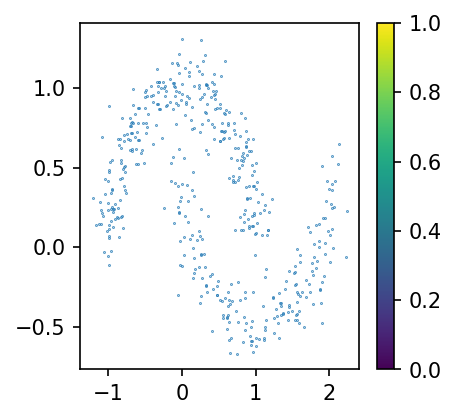

In [62]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
X, y = make_moons(600, noise=0.12)
X2, y2 = make_moons(100, noise=0.12)

outer_numbers = np.where(y == 0)
inner_numbers = np.where(y == 1)
#print(outer_numbers)

outer_numbers2 = np.where(y2 == 0)
inner_numbers2 = np.where(y2 == 1)

x1 = X[outer_numbers]
x2 = X[inner_numbers]
print(x1.shape)
x2 = x2[0:200]
print(x2.shape)

XX = np.append(x1,x2, axis=0)
XX.shape
X =XX
plt.figure(dpi=150, figsize=(3,3))
plt.scatter(X[:, 0], X[:, 1], s=0.1, cmap='Spectral')
#plt.scatter(embedding_norm[idx0,0], embedding_norm[idx0,1],  s=0.2, cmap='Spectral')
plt.colorbar()

In [63]:
#g = filters.Abspline(G, Nf = m + 1)



def wavelet_diffuse_sampler(graph):
    """Sample from the diffusion distribution
    using fitted density and nearest neighbor models.

    Parameters
    ----------
    graph: array
       
    
    n_pos : int
        Sample size of edges to be sampled during SGD optimization.

    Returns
    -------
    edges: array, shape (n_pos,)
        contains indices nearest neighbor edges from input distribution used to fit kdemodel and nbrs model.

    """
    # Construct graph and kernel wavelet g using the graph G 
    import random
    m  =  5
    G = graphs.Graph(graph)
    G.estimate_lmax()
    g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)
    N = G.N
    my_diff_val = {}
    my_diff_index = {}
    Thresh = 0.001
## choose band number to smaple 
    band_to_sample = 0
# initialize dictionaries where each key is the node and items its neighbors 
# my_diff_index stores the diffusion wavelet neighbors indices of each node i 
    for i in range(N):
        my_diff_val[i] = None
    for i in range(N):
        my_diff_index[i] = None
    
    #wavelet_at_node = g.filter(delta_node)
    for i in range(N):   
        delta_node = np.zeros((G.N,))
        delta_node[i] = 1
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        idx = np.where(signal>Thresh)
        signal2 = signal[idx]
        my_diff_val[i] = signal2
        my_diff_index[i] = idx
###########################################################
    data = my_diff_index
    arrays = []
    
# Loop through the values of the dictionary and create an array for each value
    for d in data.values():
        arrays.append(d)

    idx_per_array = []
    for k in data.keys():
        current_diff_arr = arrays[k]
        current_diff_arr = np.array(current_diff_arr)
        idx_per_array.append(current_diff_arr.shape[1])
    print(np.sum(idx_per_array))
    pos_edges = np.array(list(data.values()))
    #pos_edges = arrays
    
    return pos_edges, my_diff_val

In [64]:
@njit
def extract_value(arrays, i, j):
    """Extracts a value from a list of NumPy arrays."""
    return arrays[i][j]


import random
import numpy as np
from numba import njit
from numba.typed import List


#@njit
def optimize_layout_diffusion(embedding,
                    n_edge_samples, n_vertices, pos_edges,
                    a, b, rng_state, gamma=1.0, initial_alpha=1.0,
                    negative_sample_rate=5, verbose=False):

 
    
    dim = embedding.shape[1]
    alpha = initial_alpha
    ##########################3
    INT32_MIN = np.iinfo(np.int32).min + 1
    INT32_MAX = np.iinfo(np.int32).max - 1
#    rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

# Loop through the values of the dictionary and create an array for each value

    for i in range(n_edge_samples):

        if i % negative_sample_rate == 0:
            is_negative_sample = False
        else:
            is_negative_sample = True

        if is_negative_sample:
            edge = tau_rand_int(rng_state) % (n_vertices ** 2)
            j = edge // n_vertices
            k = edge % n_vertices
        else:

            j = tau_rand_int(rng_state) % n_vertices
            
            j_array = pos_edges[j]
            len_arr = len(j_array[0])
            k = tau_rand_int(rng_state) % len_arr
       #     k = random.randint(0, k_idx - 1)
            
            current = embedding[j]
            other = embedding[k]
        
        dist_squared = rdist(current, other)

        if is_negative_sample:

            grad_coeff = (2.0 * gamma * b)
            grad_coeff /= (0.001 + dist_squared) * (
                a * pow(dist_squared, b) + 1)

            if not np.isfinite(grad_coeff):
                grad_coeff = 8.0

        else:

            grad_coeff = (-2.0 * a * b * pow(dist_squared, b - 1.0))
            grad_coeff /= (a * pow(dist_squared, b) + 1.0)

        for d in range(dim):
            grad_d = clip(grad_coeff * (current[d] - other[d]))
            current[d] += grad_d * alpha
            other[d] += -grad_d * alpha

        if i % 10000 == 0:
            # alpha = np.exp(
            #     -0.69314718055994529 * (
            #     (3 * i) / n_edge_samples) ** 2) * initial_alpha
            alpha = (1.0 - np.sqrt(float(i) / n_edge_samples)) * initial_alpha
            if alpha < (initial_alpha * 0.000001):
                alpha = initial_alpha * 0.000001

        if verbose and i % int(n_edge_samples/10) == 0 :
            print("\tembedding iteration ", i, " / ", n_edge_samples)

    return embedding    

In [65]:
@numba.njit()
def optimize_layout(embedding, positive_head, positive_tail,
                    n_edge_samples, n_vertices, prob, alias,
                    a, b, rng_state, gamma=1.0, initial_alpha=1.0,
                    negative_sample_rate=5, verbose=False):
   
    dim = embedding.shape[1]
    alpha = initial_alpha

    for i in range(n_edge_samples):

        if i % negative_sample_rate == 0:
            is_negative_sample = False
        else:
            is_negative_sample = True

        if is_negative_sample:
            edge = tau_rand_int(rng_state) % (n_vertices ** 2)
            j = edge // n_vertices
            k = edge % n_vertices
        else:
            edge = sample(prob, alias, rng_state)
            j = positive_head[edge]
            k = positive_tail[edge]

        current = embedding[j]
        other = embedding[k]

        dist_squared = rdist(current, other)

        if is_negative_sample:

            grad_coeff = (2.0 * gamma * b)
            grad_coeff /= (0.001 + dist_squared) * (
                a * pow(dist_squared, b) + 1)

            if not np.isfinite(grad_coeff):
                grad_coeff = 8.0

        else:

            grad_coeff = (-2.0 * a * b * pow(dist_squared, b - 1.0))
            grad_coeff /= (a * pow(dist_squared, b) + 1.0)

        for d in range(dim):
            grad_d = clip(grad_coeff * (current[d] - other[d]))
            current[d] += grad_d * alpha
            other[d] += -grad_d * alpha

        if i % 10000 == 0:
            # alpha = np.exp(
            #     -0.69314718055994529 * (
            #     (3 * i) / n_edge_samples) ** 2) * initial_alpha
            alpha = (1.0 - np.sqrt(float(i) / n_edge_samples)) * initial_alpha
            if alpha < (initial_alpha * 0.000001):
                alpha = initial_alpha * 0.000001

        if verbose and i % int(n_edge_samples/10) == 0 :
            print("\tembedding iteration ", i, " / ", n_edge_samples)

    return embedding

In [66]:
def wavelet_diffuse_sampler(graph):
    """Sample from the diffusion distribution
    using fitted density and nearest neighbor models.

    Parameters
    ----------
    graph: array

    """
    # Construct graph and kernel wavelet g using the graph G 
    import random
    m  =  5
    G = graphs.Graph(graph)
    G.estimate_lmax()
    g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)
    N = G.N
    my_diff_val = {}
    my_diff_index = {}
    Thresh = 0.001
## choose band number to smaple 
    band_to_sample = 1
# initialize dictionaries where each key is the node and items its neighbors 
# my_diff_index stores the diffusion wavelet neighbors indices of each node i 
    for i in range(N):
        my_diff_val[i] = None
    for i in range(N):
        my_diff_index[i] = None
    
    #wavelet_at_node = g.filter(delta_node)
    for i in range(N):   
        delta_node = np.zeros((G.N,))
        delta_node[i] = 1
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        idx = np.where(signal>Thresh)
        signal2 = signal[idx]
        my_diff_val[i] = signal2
        my_diff_index[i] = idx
###########################################################
    data = my_diff_index
    arrays = []
    
# Loop through the values of the dictionary and create an array for each value
    for d in data.values():
        arrays.append(d)

    idx_per_array = []
    for k in data.keys():
        current_diff_arr = arrays[k]
        current_diff_arr = np.array(current_diff_arr)
        idx_per_array.append(current_diff_arr.shape[1])
    print(np.sum(idx_per_array))
    pos_edges = np.array(list(data.values()))
    #pos_edges = arrays
    
    return pos_edges, my_diff_val, idx_per_array

In [67]:
def wavelet_diffuse_sampler2(graph):
    """Sample from the diffusion distribution
    using fitted density and nearest neighbor models.

    Parameters
    ----------
    graph: array

    """
    # Construct graph and kernel wavelet g using the graph G 
    import random
    m  =  5
    G = graphs.Graph(graph)
    G.estimate_lmax()
    g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)
    N = G.N
    my_diff_val = {}
    my_diff_index = {}
    Thresh = 0.00
## choose band number to smaple 
    band_to_sample = 1
    flat_array_sampled_pair = []
    flat_array_positive = []
# initialize dictionaries where each key is the node and items its neighbors 
# my_diff_index stores the diffusion wavelet neighbors indices of each node i 
    for i in range(N):
        my_diff_val[i] = None
    for i in range(N):
        my_diff_index[i] = None

    #wavelet_at_node = g.filter(delta_node)
    for i in range(N):  
        delta_node = np.zeros((G.N,))
        delta_node[i] = 1
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        signal[i]=0
        idx = np.where(signal>Thresh)
        
        #idx[i] = 0
        signal2 = signal[idx]
        my_diff_val[i] = signal2
        my_diff_index[i] = idx
        
        idx = np.array(idx)
#        del idx[i]
       # idx_t = np.array(idx)
        l = idx.shape[1]
        idx_t = i*np.ones(l)
        
        flat_array_sampled_pair = np.concatenate((flat_array_sampled_pair, idx), axis=None)
        flat_array_positive = np.concatenate((flat_array_positive, idx_t), axis=None)


    data = my_diff_index
    

    return flat_array_positive, flat_array_sampled_pair

In [68]:
from sklearn.utils import check_random_state

In [69]:
feats = X
#knn = 10
num_filters = 5
m = 5
n_neighbors = 10
metric='euclidean'
n_edge_samples=None
spread=1.0
min_dist=0.1
random_state=None
metric_kwds={}
angular_rp_forest=False
method = 'method 1'
verbose=False
####Optionally, we compute SGW and retain the smoohtest bands and use them as feature embeddings. However our default is to use 
#### the regularized SGW "embedding_noembed" 
graph = fuzzy_simplicial_set(X, n_neighbors, check_random_state(None), metric,metric_kwds,angular_rp_forest,verbose)
#G = graphs.NNGraph(feats, NNtype='knn', k=10)
G = graphs.Graph(graph)
G.coords = feats
#print(G.e)
g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)



print(f'{G.N} nodes, {G.Ne} edges')

/tmp/ipykernel_143/2336351230.py:933: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'callable': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "../../../../../../tmp/ipykernel_143/2336351230.py", line 1015:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/tmp/ipykernel_143/2336351230.py:933: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'callable': Cannot determine Numba type of <class 'builtin_function_or_method'>

File "../../../../../../tmp/ipykernel_143/2336351230.py", line 1015:
<source missing, REPL/exec in use?>

  @numba.jit(parallel=True)
/usr/local/lib64/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in obje

500 nodes, 2768 edges


In [70]:
n_vertices = G.N
negative_sample_rate = 5
a = 1 
b =1 
gamma=1.0
pos_edges, my_diff_val,idx_per_array = wavelet_diffuse_sampler(graph)
g2 = graphs.Graph(graph)
g2.estimate_lmax()
#pos_edges = positive_edges_arrays
n_edge_samples = (graph.shape[0] // 150) * 1000000
print("default")
print(n_edge_samples)
sgw_kernel = 'mexican hat'
sgw_num_filters = 5
sgw_num_keep = 3
method = 'method 1'

graph = graph.tocoo()
graph.sum_duplicates()
positive_head = graph.row
positive_tail = graph.col
initial_alpha=1.0

##Initialzing the random state object 
random_state=None
INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1
random_state = check_random_state(random_state)

rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

prob, alias = create_sampler(graph.data)

27462
default
3000000


/tmp/ipykernel_143/3646160186.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pos_edges = np.array(list(data.values()))
/tmp/ipykernel_143/708304556.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "create_sampler" failed type inference due to: Untyped global name 'deque': Cannot determine Numba type of <class 'type'>

File "../../../../../../tmp/ipykernel_143/708304556.py", line 33:
<source missing, REPL/exec in use?>

  @numba.jit()
/usr/local/lib64/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "create_sampler" was compiled in object mode without forceobj=True.

File "../../../../../../tmp/ipykernel_143/708304556.py", line 1:
<source missing, REPL/exec in use?>

  wa

In [71]:
X = X.astype(np.float64)
embedding = X

filtered_embedding, sgw_filter_embedding = construct_SGW(sgw_num_filters,
                                                                embedding,
                                                                g2,
                                                                sgw_num_keep,
                                                                sgw_kernel,
                                                                method)

In [72]:
filtered_embedding = optimize_layout(filtered_embedding, positive_head, positive_tail,
                                            n_edge_samples, n_vertices,
                                            prob,alias, a, b, rng_state, gamma,
                                            initial_alpha, verbose=verbose)

In [73]:
#filtered_embedding = optimize_layout_diffusion(filtered_embedding, n_edge_samples, n_vertices, pos_edges,
#                                                       a, b, rng_state, gamma=1.0, initial_alpha=1.0, negative_sample_rate=5, verbose=False)

/home/sdeuts1/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


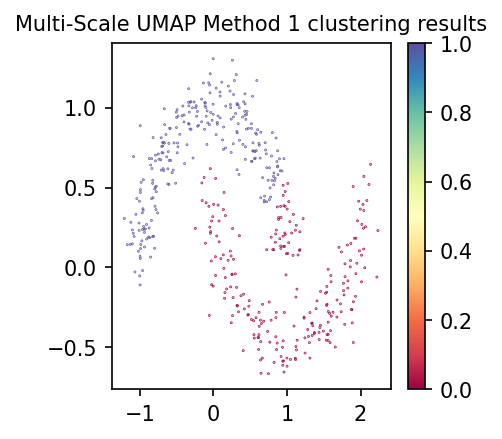

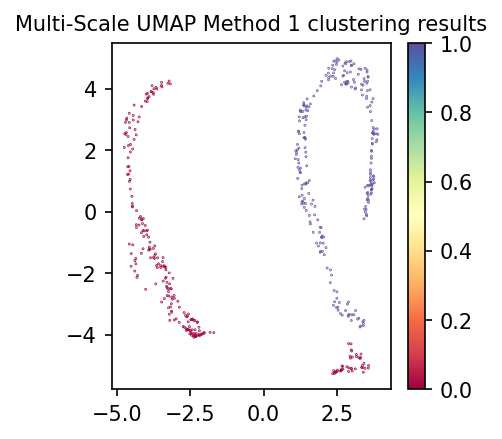

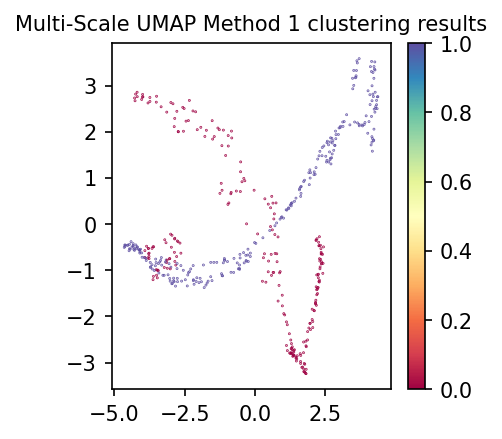

In [74]:
kmeans_labels_multi_scale1 = cluster.KMeans(n_clusters = 2).fit_predict(filtered_embedding)

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
#kmeans_labelsu = cluster.KMeans(n_clusters = 2).fit_predict(embeddingumap)

plt.figure(dpi=150, figsize=(3,3))
plt.scatter(X[:,0], X [:,1], c=kmeans_labels_multi_scale1,  s=0.1, cmap='Spectral')
plt.title("Multi-Scale UMAP Method 1 clustering results", fontsize = 10)
plt.colorbar()

plt.figure(dpi=150, figsize=(3,3))
plt.scatter(filtered_embedding[:,0], filtered_embedding [:,1], c=kmeans_labels_multi_scale1,  s=0.1, cmap='Spectral')
plt.title("Multi-Scale UMAP Method 1 clustering results", fontsize = 10)
plt.colorbar()

plt.figure(dpi=150, figsize=(3,3))
plt.scatter(filtered_embedding[:,2], filtered_embedding [:,3], c=kmeans_labels_multi_scale1,  s=0.1, cmap='Spectral')
plt.title("Multi-Scale UMAP Method 1 clustering results", fontsize = 10)
plt.colorbar()

In [75]:
def wavelet_diffusion_learning(feats, graph, node_spread):

    diffusion_matrix0 = np.zeros((feats.shape[0],feats.shape[0]))
    diffusion_matrix1 = np.zeros((feats.shape[0],feats.shape[0]))
    diffusion_matrix2 = np.zeros((feats.shape[0],feats.shape[0]))
    diffusion_matrix3 = np.zeros((feats.shape[0],feats.shape[0]))
    diffusion_matrix_full = np.zeros((feats.shape[0],feats.shape[0]))

    m  =  4
    G = graphs.Graph(graph)
    G.estimate_lmax()
    g = filters.MexicanHat(G, Nf = m + 1, lpfactor = 50)
    N = G.N
   
 
    band_to_sample = 0
    for i in range(N):   
        delta_node = np.zeros((G.N,))
        delta_node[i] = node_spread
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        diffusion_matrix0[:,i]= signal
    
    band_to_sample = 1
    for i in range(N):   
        delta_node = np.zeros((G.N,))
        delta_node[i] = node_spread
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        diffusion_matrix1[:,i]= signal

    band_to_sample = 2
    for i in range(N):   
        delta_node = np.zeros((G.N,))
        delta_node[i] = node_spread
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        diffusion_matrix2[:,i]= signal
        
    band_to_sample = 3
    for i in range(N):   
        delta_node = np.zeros((G.N,))
        delta_node[i] = node_spread
        wavelet_at_node = g.filter(delta_node)
        signal = wavelet_at_node[:,band_to_sample]
        diffusion_matrix3[:,i]= signal
#        
        
    diffusion_matrix_full = diffusion_matrix0 + diffusion_matrix1 + diffusion_matrix2 + diffusion_matrix3
    
    return diffusion_matrix_full 

In [76]:
node_spread = n_neighbors

diffusion_matrix_full = wavelet_diffusion_learning(feats, graph, node_spread)

np.fill_diagonal(diffusion_matrix_full, 0)

diffusion_matrix_full_s = (diffusion_matrix_full  + diffusion_matrix_full.T)/2
diffusion_matrix_full = np.maximum(diffusion_matrix_full, 0)
diffusion_matrix_full_s = np.maximum(diffusion_matrix_full_s, 0)

diffusion_matrix_full = diffusion_matrix_full_s

In [77]:
#diffusion_matrix= wavelet_diffusion_learning(feats, graph, node_spread)
#np.fill_diagonal(diffusion_matrix, 0)
#diffusion_matrix_full = np.maximum(diffusion_matrix_full, 0)
#diffusion_matrix_full = diffusion_matrix*diffusion_matrix.T



In [78]:
result = scipy.sparse.coo_matrix(diffusion_matrix_full)
graph = result
graph = graph.tocoo()
graph.sum_duplicates()
positive_head = graph.row
positive_tail = graph.col
initial_alpha=1.0

In [79]:
##Initialzing the random state object 
random_state=None
INT32_MIN = np.iinfo(np.int32).min + 1
INT32_MAX = np.iinfo(np.int32).max - 1
random_state = check_random_state(random_state)

rng_state = random_state.randint(INT32_MIN, INT32_MAX, 3).astype(np.int64)

prob, alias = create_sampler(graph.data)

g2 = graphs.Graph(graph)
g2.estimate_lmax()
#pos_edges = positive_edges_arrays
n_edge_samples = (graph.shape[0] // 150) * 1000000
print("default")
print(n_edge_samples)
sgw_kernel = 'mexican hat'
sgw_num_filters = 5
sgw_num_keep = 3
method = 'method 1'

default
3000000


In [80]:
X = X.astype(np.float64)
embedding = X

filtered_embedding, sgw_filter_embedding = construct_SGW(sgw_num_filters,
                                                                embedding,
                                                                g2,
                                                                sgw_num_keep,
                                                                sgw_kernel,
                                                                method)

In [81]:
filtered_embedding = optimize_layout(filtered_embedding, positive_head, positive_tail,
                                            n_edge_samples, n_vertices,
                                            prob,alias, a, b, rng_state, gamma,
                                            initial_alpha, verbose=verbose)

500 nodes, 12966 edges


/home/sdeuts1/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10

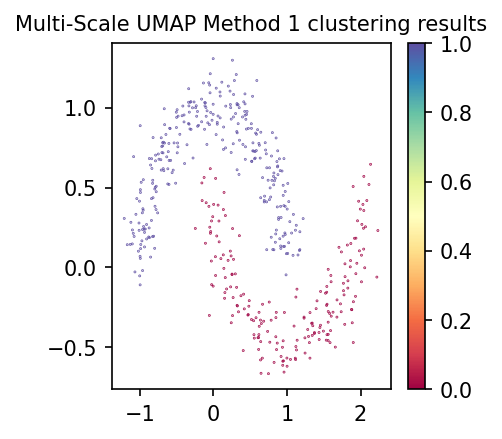

In [82]:
G = graphs.Graph(graph)

print(f'{G.N} nodes, {G.Ne} edges')

kmeans_labels_multi_scale1 = cluster.KMeans(n_clusters = 2).fit_predict(filtered_embedding)

import sklearn.cluster as cluster
from sklearn.cluster import KMeans
#kmeans_labelsu = cluster.KMeans(n_clusters = 2).fit_predict(embeddingumap)

plt.figure(dpi=150, figsize=(3,3))
plt.scatter(X[:,0], X [:,1], c=kmeans_labels_multi_scale1,  s=0.1, cmap='Spectral')
plt.title("Multi-Scale UMAP Method 1 clustering results", fontsize = 10)
plt.colorbar()




node_spread

In [83]:
diffusion_matrix_full = wavelet_diffusion_learning(feats, graph, node_spread)
diffusion_matrix_var = diffusion_matrix_full*diffusion_matrix_full.T
#diffusion_matrix= wavelet_diffusion_learning(feats, graph, node_spread)
#np.fill_diagonal(diffusion_matrix, 0)
#diffusion_matrix_full = np.maximum(diffusion_matrix_full, 0)

(array([ 3.,  3.,  1.,  4.,  2.,  9.,  5.,  6., 12., 13.,  7., 11.,  9.,
        15., 16., 13., 22.,  9., 17., 17., 15.,  9., 12.,  9.,  8., 13.,
        16., 12., 11., 16.,  7.,  8., 15.,  6., 12.,  6.,  8.,  7.,  9.,
         7.,  5.,  1.,  6.,  4.,  8.,  4.,  1.,  8.,  1.,  4.,  3.,  1.,
         1.,  3.,  3.,  4.,  2.,  3.,  1.,  2.,  0.,  3.,  0.,  4.,  1.,
         1.,  1.,  2.,  2.,  2.,  2.,  1.,  1.,  2.,  0.,  1.,  1.,  2.,
         0.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.74285933, 0.79214769, 0.84143605, 0.8907244 , 0.94001276,
        0.98930111, 1.03858947, 1.08787783, 1.13716618, 1.18645454,
        1.23574289, 1.28503125, 1.33431961, 1.38360796, 1.43289632,
        1.48218467, 1.53147303, 1.58076138, 1.63004974, 1.6793381 ,
        1.72862645, 1.77791481, 1.82720316, 1.87649152, 1.92577988,
        1.97506823, 2.02435659, 2.07364494, 2.1229333 , 2.17222166,
        2.22151001, 2.2707

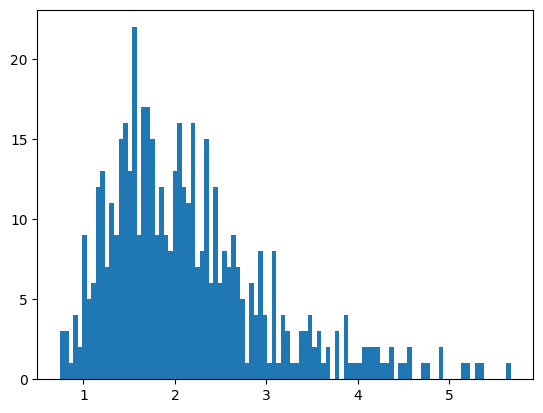

In [92]:
diag_val = np.diag(diffusion_matrix_var)
diag_val.shape
plt.hist(diag_val, bins= 100)

In [93]:
diag_val_norm =  diag_val/np.max(diag_val) 

plt.hist(diag_val_norm, bins= 20)

In [97]:
diag_val_norm.shape
type(diag_val_norm)
diag_val_norm = np.array(diag_val_norm)

In [99]:
kdemodel = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(diag_val_norm)

ValueError: Expected 2D array, got 1D array instead:
array=[0.32492037 0.41613306 0.22872652 0.64769171 0.2049799  0.27829153
 0.5176064  0.68145063 0.40444119 0.25359856 0.31805519 0.27280151
 0.51518132 0.56427744 0.16036982 0.84058781 0.27712971 0.27397523
 0.43891435 0.2330082  0.50349424 0.56102296 0.4330729  0.350161
 0.24021308 0.56409938 0.24321908 0.38891818 0.2537886  0.3328321
 0.18885607 0.63376099 0.30030928 0.86243573 0.39566148 0.24443832
 0.33553172 0.26670232 0.31841143 0.23333777 0.22152912 0.49688312
 0.31063916 0.27105251 0.60504675 0.30047422 0.26974999 0.34938287
 0.27802963 0.32836087 0.35160591 0.80510863 0.40212722 0.76761951
 0.33545726 0.63403382 0.30979633 0.33148709 0.37154928 0.36416255
 0.47799151 0.50128849 0.40649177 0.35652739 0.22148327 0.16500833
 0.25361603 0.39464312 0.28044746 0.45193015 0.36317919 0.41118623
 0.35642057 0.26002456 0.58948302 0.42960404 0.42840116 0.1309766
 0.24277359 0.37510348 0.66296711 0.4490852  0.42146121 0.26916436
 0.3781362  0.41212423 0.45795366 0.3052114  0.30044609 0.46428692
 0.30962355 0.21265321 0.27744388 0.68569753 0.42646739 0.15749422
 0.30276842 0.47787092 0.4229328  0.35214476 0.39850073 0.26426823
 0.52806891 0.30242081 0.20608138 0.27225506 0.29093265 0.50549657
 0.45013149 0.24981195 0.9402288  0.23431933 0.52601982 0.35637078
 0.38736151 0.29675885 0.48144345 0.24454932 0.75864987 0.31631929
 0.4676518  0.24090443 0.30544294 0.33467016 0.2164989  0.23012471
 0.45030097 0.57750871 0.24828814 0.63162593 0.22569549 0.28949562
 0.24586557 0.38712526 0.29987957 0.24222353 0.72398649 0.2955068
 0.33293349 0.31356395 0.3648727  0.21257673 0.28042236 0.65005929
 0.40674104 0.25570873 0.38133012 0.38104006 0.25996813 0.2891467
 0.23802494 0.27219366 0.422267   0.247887   0.20641132 0.51148858
 0.46570769 0.32653422 0.34711117 0.45906212 0.34249625 0.19763862
 0.20253572 0.43555537 0.37946439 0.41296778 0.31224504 0.42007095
 0.29676608 0.20333459 0.59906146 0.38438505 0.35635982 0.21331102
 0.26795395 0.34016383 0.90874189 0.27257596 0.28160348 0.23318713
 0.36826506 0.26675923 0.45544161 0.29740679 0.17623898 0.46498602
 0.60753646 0.32115347 0.31135558 0.25862701 0.46279138 0.46745625
 0.24892158 0.26938083 0.91729545 0.38560463 0.29897786 0.28913565
 0.3232304  0.17218591 0.49618237 0.28497187 0.602028   0.42782102
 0.24679928 0.20847337 0.27384411 0.61040898 0.32609627 0.38182437
 0.54524568 0.46958366 0.3252438  0.30308744 0.50914989 0.19064662
 0.55735769 0.38361973 0.73882397 0.33916005 0.29244458 0.2746857
 0.44877327 0.18096445 0.30037145 0.43630068 0.32544174 0.36162258
 0.32069619 0.51708694 0.1405708  0.3522872  0.43525441 0.76872827
 0.20672306 0.29237586 0.41203231 0.47305152 0.32664562 0.22842466
 0.30804594 0.30741092 0.42693512 0.4148939  0.68459402 0.30265187
 0.37726832 0.36297102 0.27381016 0.37389643 0.73122114 0.2531611
 0.24705867 0.41784225 0.35867614 0.74264254 0.21731017 0.55379324
 0.31880035 0.31675128 0.41337573 0.32255765 0.3706732  0.40107147
 0.59463816 0.54662652 0.37065062 0.69237003 0.35630858 0.35874911
 0.5016918  0.25638854 0.29399064 0.2619267  0.24789653 0.28469955
 0.51592016 0.290923   0.28180964 0.34230631 0.38307282 0.44928888
 0.2774298  0.38472565 0.29267289 0.28924014 0.42398363 0.247862
 0.53723121 0.3712273  0.21982232 0.26715631 0.37421031 0.34631677
 0.52531226 0.38673384 0.25363131 0.34121132 0.72232299 0.52039
 0.37510175 0.43292098 0.32929488 0.26133093 0.66296614 0.17784319
 0.36179815 0.36628975 0.24804016 0.27773387 0.21619344 0.74383646
 0.48392319 0.20544526 0.45849304 0.25330841 0.36755725 0.20594203
 0.18253625 0.13350219 0.30441228 0.46037948 0.46657005 0.29934857
 0.29559551 0.27582665 0.42823939 0.33150742 0.50293228 0.17359094
 0.3948599  0.78965402 0.29680144 0.35015974 0.37602233 0.36018425
 0.41413551 0.19994803 0.68208963 0.20326113 0.38432301 0.29349695
 0.54223983 0.25879535 0.27373434 0.61375069 0.27368221 0.38738343
 0.43492948 0.61524163 0.42967294 0.46416301 0.1788229  0.69872004
 0.71716764 0.30451234 0.2177152  0.22673916 0.28724157 0.49107249
 0.13508785 0.45850841 0.39454793 0.37217342 0.35903583 0.31327406
 0.20443694 0.35201299 0.19866265 0.51787123 0.86770286 0.2467866
 0.52089777 0.32670118 0.3378364  0.24121399 0.63673014 0.47338966
 0.66280472 0.40379771 0.29055249 0.26317773 0.37572855 0.54436229
 0.24895382 0.2767555  0.38324352 0.28826863 0.43879799 0.48115948
 0.14924007 0.20299922 0.2799317  0.52976125 0.31393994 0.31153161
 0.38810466 0.56787045 0.79276548 0.59366081 0.19547591 0.43042014
 0.25949637 0.19844075 0.19695297 0.21314583 0.40213672 0.31001265
 0.61643723 0.37250522 0.35968473 0.41340099 0.54214197 0.5050051
 0.32741344 0.45186386 0.38332342 0.21667924 0.24032004 0.19003715
 0.31250191 0.93372336 0.44818035 0.40469096 0.21607714 0.75178997
 0.22167529 0.48394729 0.41293576 0.18419047 0.28316867 0.14146293
 0.40933767 0.25577925 0.2702903  0.42771234 0.54754694 0.62490814
 0.27094944 0.61912538 0.36394906 0.38574154 0.31002448 0.2754661
 0.71781242 0.47702388 0.36156367 0.28865261 0.38704088 0.82798847
 0.35887839 0.30944949 0.35866704 0.17966672 0.48116844 0.25466865
 0.2627603  0.34891494 0.37420007 0.2125894  0.26326832 0.23124655
 0.51633432 0.18222914 0.36544269 0.25000476 0.1895622  0.39782331
 0.17987979 0.45437838 0.41155909 0.23299477 0.22528763 0.34672919
 0.71291516 0.56942939 0.21295784 0.18165625 0.54770347 0.15949211
 0.37839005 0.47190397 0.80167649 0.22892303 0.21344109 0.56795449
 0.44343711 0.2381924  0.29063024 0.5405868  1.         0.14246985
 0.34679233 0.47623638 0.22466714 0.40972385 0.41623704 0.39385575
 0.25392903 0.41762767].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

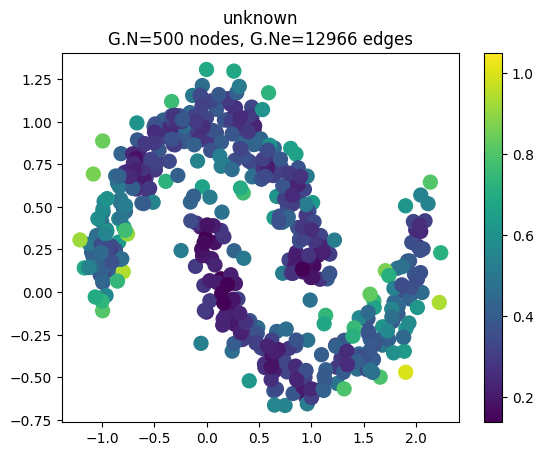

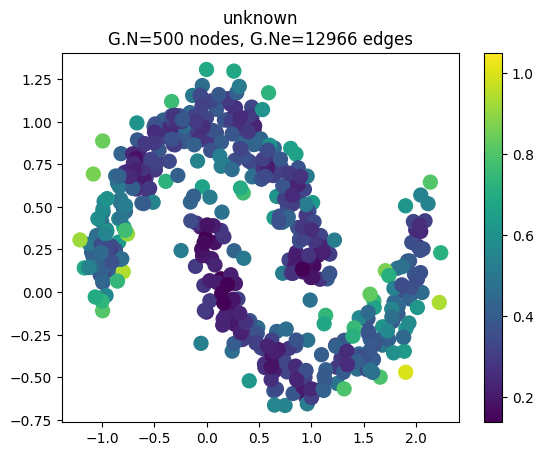

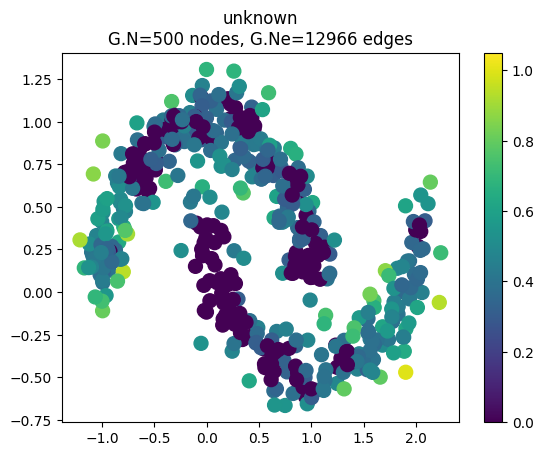

In [87]:
G.coords = feats
diag_val2= diag_val/np.max(diag_val)
diag_val = diag_val_norm
idx= np.where(diag_val<0.3)
diag_val3 = diag_val
diag_val3 = np.array(diag_val3)


diag_val3[idx] = 0

G.plot_signal(diag_val) # the delta signal centered on 'node'
G.plot_signal(diag_val2)
G.plot_signal(diag_val3)
#G.plot_signal(wavelet_at_node[:,4]) # the wavelet at the same node but at slightly larger scale (smaller value of s)

In [47]:
start = time.time()
## create the betweenness centrality graph       
bgraph = betweenness_graph(graph)
bgraph = bgraph.tocoo()
bgraph.sum_duplicates()
stop = time.time()
print(stop - start)
n_pos = len(graph.data)
### Sample from the EBC distribution
start = time.time()
# nbrs- the indices of edges sampled from the EBC distribution, kdemode - CDF
nbrs, kdemodel = betweenness_fit(bgraph)
stop = time.time()
print(stop - start)

start = time.time()
pos_edges = betweenness_sampler(nbrs, kdemodel, n_pos)
stop = time.time()
print(stop - start)



def betweenness_sampler(nbrs, kdemodel, n_pos):
    """Sample from the edge betweenness centrality distribution
    using fitted density and nearest neighbor models.

    Parameters
    ----------
    nbrs: object
        nearest neighbor model which outputs
        nearest neighbor indices from input distribution
    kdemodel: object
        KDE Gaussian fit of input distribution which generate new samples
    n_pos : int
        Sample size of edges to be sampled during SGD optimization.

    Returns
    -------
    edges: array, shape (n_pos,)
        contains indices nearest neighbor edges from input distribution used to fit kdemodel and nbrs model.

    """
    sample_ = kdemodel.sample(n_pos)
    edges = nbrs.kneighbors(X=sample_.reshape(-1,1), n_neighbors=1, return_distance=False).reshape(-1)
    return edges
################################################################################
def betweenness_fit(betweenness):
    """Kernel Density Estimation of the distribution
    of edge betweenness centralities of the affinity graph.
    And nearest neighbor model fit to easily search the closest
    indice in the input distribution.

    Parameters
    ----------
    betweenness : sparse matrix
        Edge betweenness centrality graph used to fit a Gaussian KDE model,
        and nearest neighbor model.


    Returns
    -------
    nbrs: object
        nearest neighbor model which outputs
        nearest neighbor indices from input distribution
    kdemodel: object
        KDE Gaussian fit of input distribution which generate new samples

    """
    kdemodel = KernelDensity(kernel='gaussian', bandwidth=0.001).fit(betweenness.data.reshape(-1, 1))
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(betweenness.data.reshape(-1,1))
    return nbrs, kdemodel

def betweenness_sampler(nbrs, kdemodel, n_pos):
    """Sample from the edge betweenness centrality distribution
    using fitted density and nearest neighbor models.

    Parameters
    ----------
    nbrs: object
        nearest neighbor model which outputs
        nearest neighbor indices from input distribution
    kdemodel: object
        KDE Gaussian fit of input distribution which generate new samples
    n_pos : int
        Sample size of edges to be sampled during SGD optimization.

    Returns
    -------
    edges: array, shape (n_pos,)
        contains indices nearest neighbor edges from input distribution used to fit kdemodel and nbrs model.

    """
    sample_ = kdemodel.sample(n_pos)
    edges = nbrs.kneighbors(X=sample_.reshape(-1,1), n_neighbors=1, return_distance=False).reshape(-1)
    return edges

57166
114
166


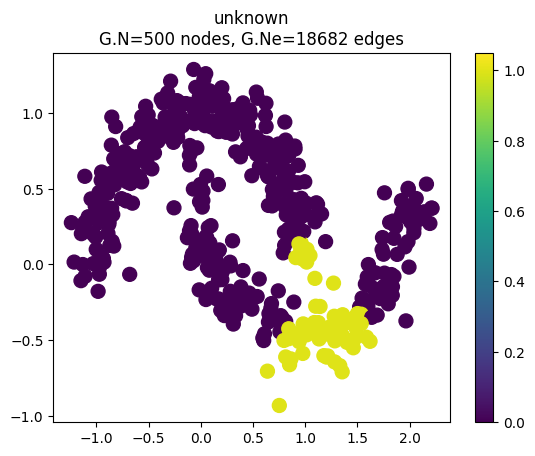

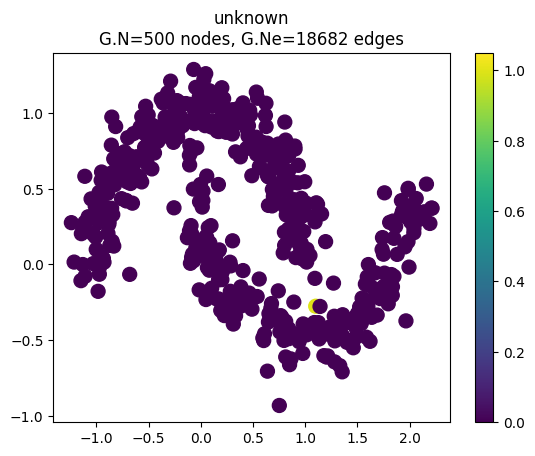

In [47]:
edge = tau_rand_int(rng_state) % (n_vertices ** 2)
j = edge // n_vertices
k = edge % n_vertices
print(edge)
print(j)
print(k)
5//6

node = 300
delta_node = np.zeros((G.N,))
idx = pos_edges[node]
signal2 = np.zeros(delta_node.shape)
signal2[node]= 1
signal = np.zeros(delta_node.shape)
signal[node]= 1
type(idx)
idx = list(idx)
signal2[idx]= 1
G.plot_signal(signal2)
G.plot_signal(signal)

In [10]:
k = tau_rand_int(rng_state) % G.N

In [54]:

n_edge_samples = (graph.shape[0] // 150) * 1000000
print(n_edge_samples)

4000000


In [ ]:
j = tau_rand_int(rng_state) % n_vertices
print(j)
j_array = pos_edges[j]
print(j_array)
#pos_edges[10][10]

k = len(my_diff_val[j])
print(k)
k_idx = tau_rand_int(rng_state) % k
print(k_idx)
j_array = pos_edges[j]
#print(j_array[0][k_idx])
print("size of array")
print(len(j_array[0]))
print(pos_edges[j])
